In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob
import shutil
from tqdm import tqdm
import pandas as pd

In [ ]:
# 내부 데이터 비교

#Train
data_path='../../data/PatchGastricADC22/f_patches_captions/'
train_csv=pd.read_csv('../../data/PatchGastricADC22/train_captions_backup.csv')
Folder_list=[]
folder_len_list=[]
for i in range(len(train_csv)):
    Folder_list.append(data_path+train_csv.loc[i]['id']+'/')
for j in tqdm(range(len(Folder_list))):
    folder_len_list.append(len(glob(Folder_list[j]+'*.jpg')))
folder_len_list = np.array(folder_len_list)     
print(f'Train \nWSI(caption) : {len(Folder_list)}\nPatch Image : {folder_len_list.sum()}\nPatch Image / WSI (P/W) : {folder_len_list.mean():06.3f}\nP/W .std : {np.std(folder_len_list):06.3f}')

#Test
test_csv=pd.read_csv('../../data/PatchGastricADC22/test_captions.csv')
Folder_list=[]
folder_len_list=[]
for i in range(len(test_csv)):
    Folder_list.append(data_path+test_csv.loc[i]['id']+'/')
for j in tqdm(range(len(Folder_list))):
    folder_len_list.append(len(glob(Folder_list[j]+'*.jpg')))
folder_len_list = np.array(folder_len_list)     
print(f'Test \nWSI(caption) : {len(Folder_list)}\nPatch Image : {folder_len_list.sum()}\nPatch Image / WSI (P/W) : {folder_len_list.mean():06.3f}\nP/W .std : {np.std(folder_len_list):06.3f}')

#Total
Folder_list=glob(data_path+'**/')
folder_len_list = []
for i in tqdm(range(len(Folder_list))):
    folder_len_list.append(len(glob(Folder_list[i]+'*.jpg')))
folder_len_list = np.array(folder_len_list)
print(f'Total \nWSI(caption) : {len(Folder_list)}\nPatch Image : {folder_len_list.sum()}\nPatch Image / WSI (P/W) : {folder_len_list.mean():06.3f}\nP/W .std : {np.std(folder_len_list):06.3f}')
plt.figure(figsize=(10, 6),dpi=600)
plt.hist(folder_len_list, bins=200, edgecolor='black', alpha=0.7)
plt.title('Number of Patch Images per WSI')
plt.xlabel('Patch Image')
plt.ylabel('WSI')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

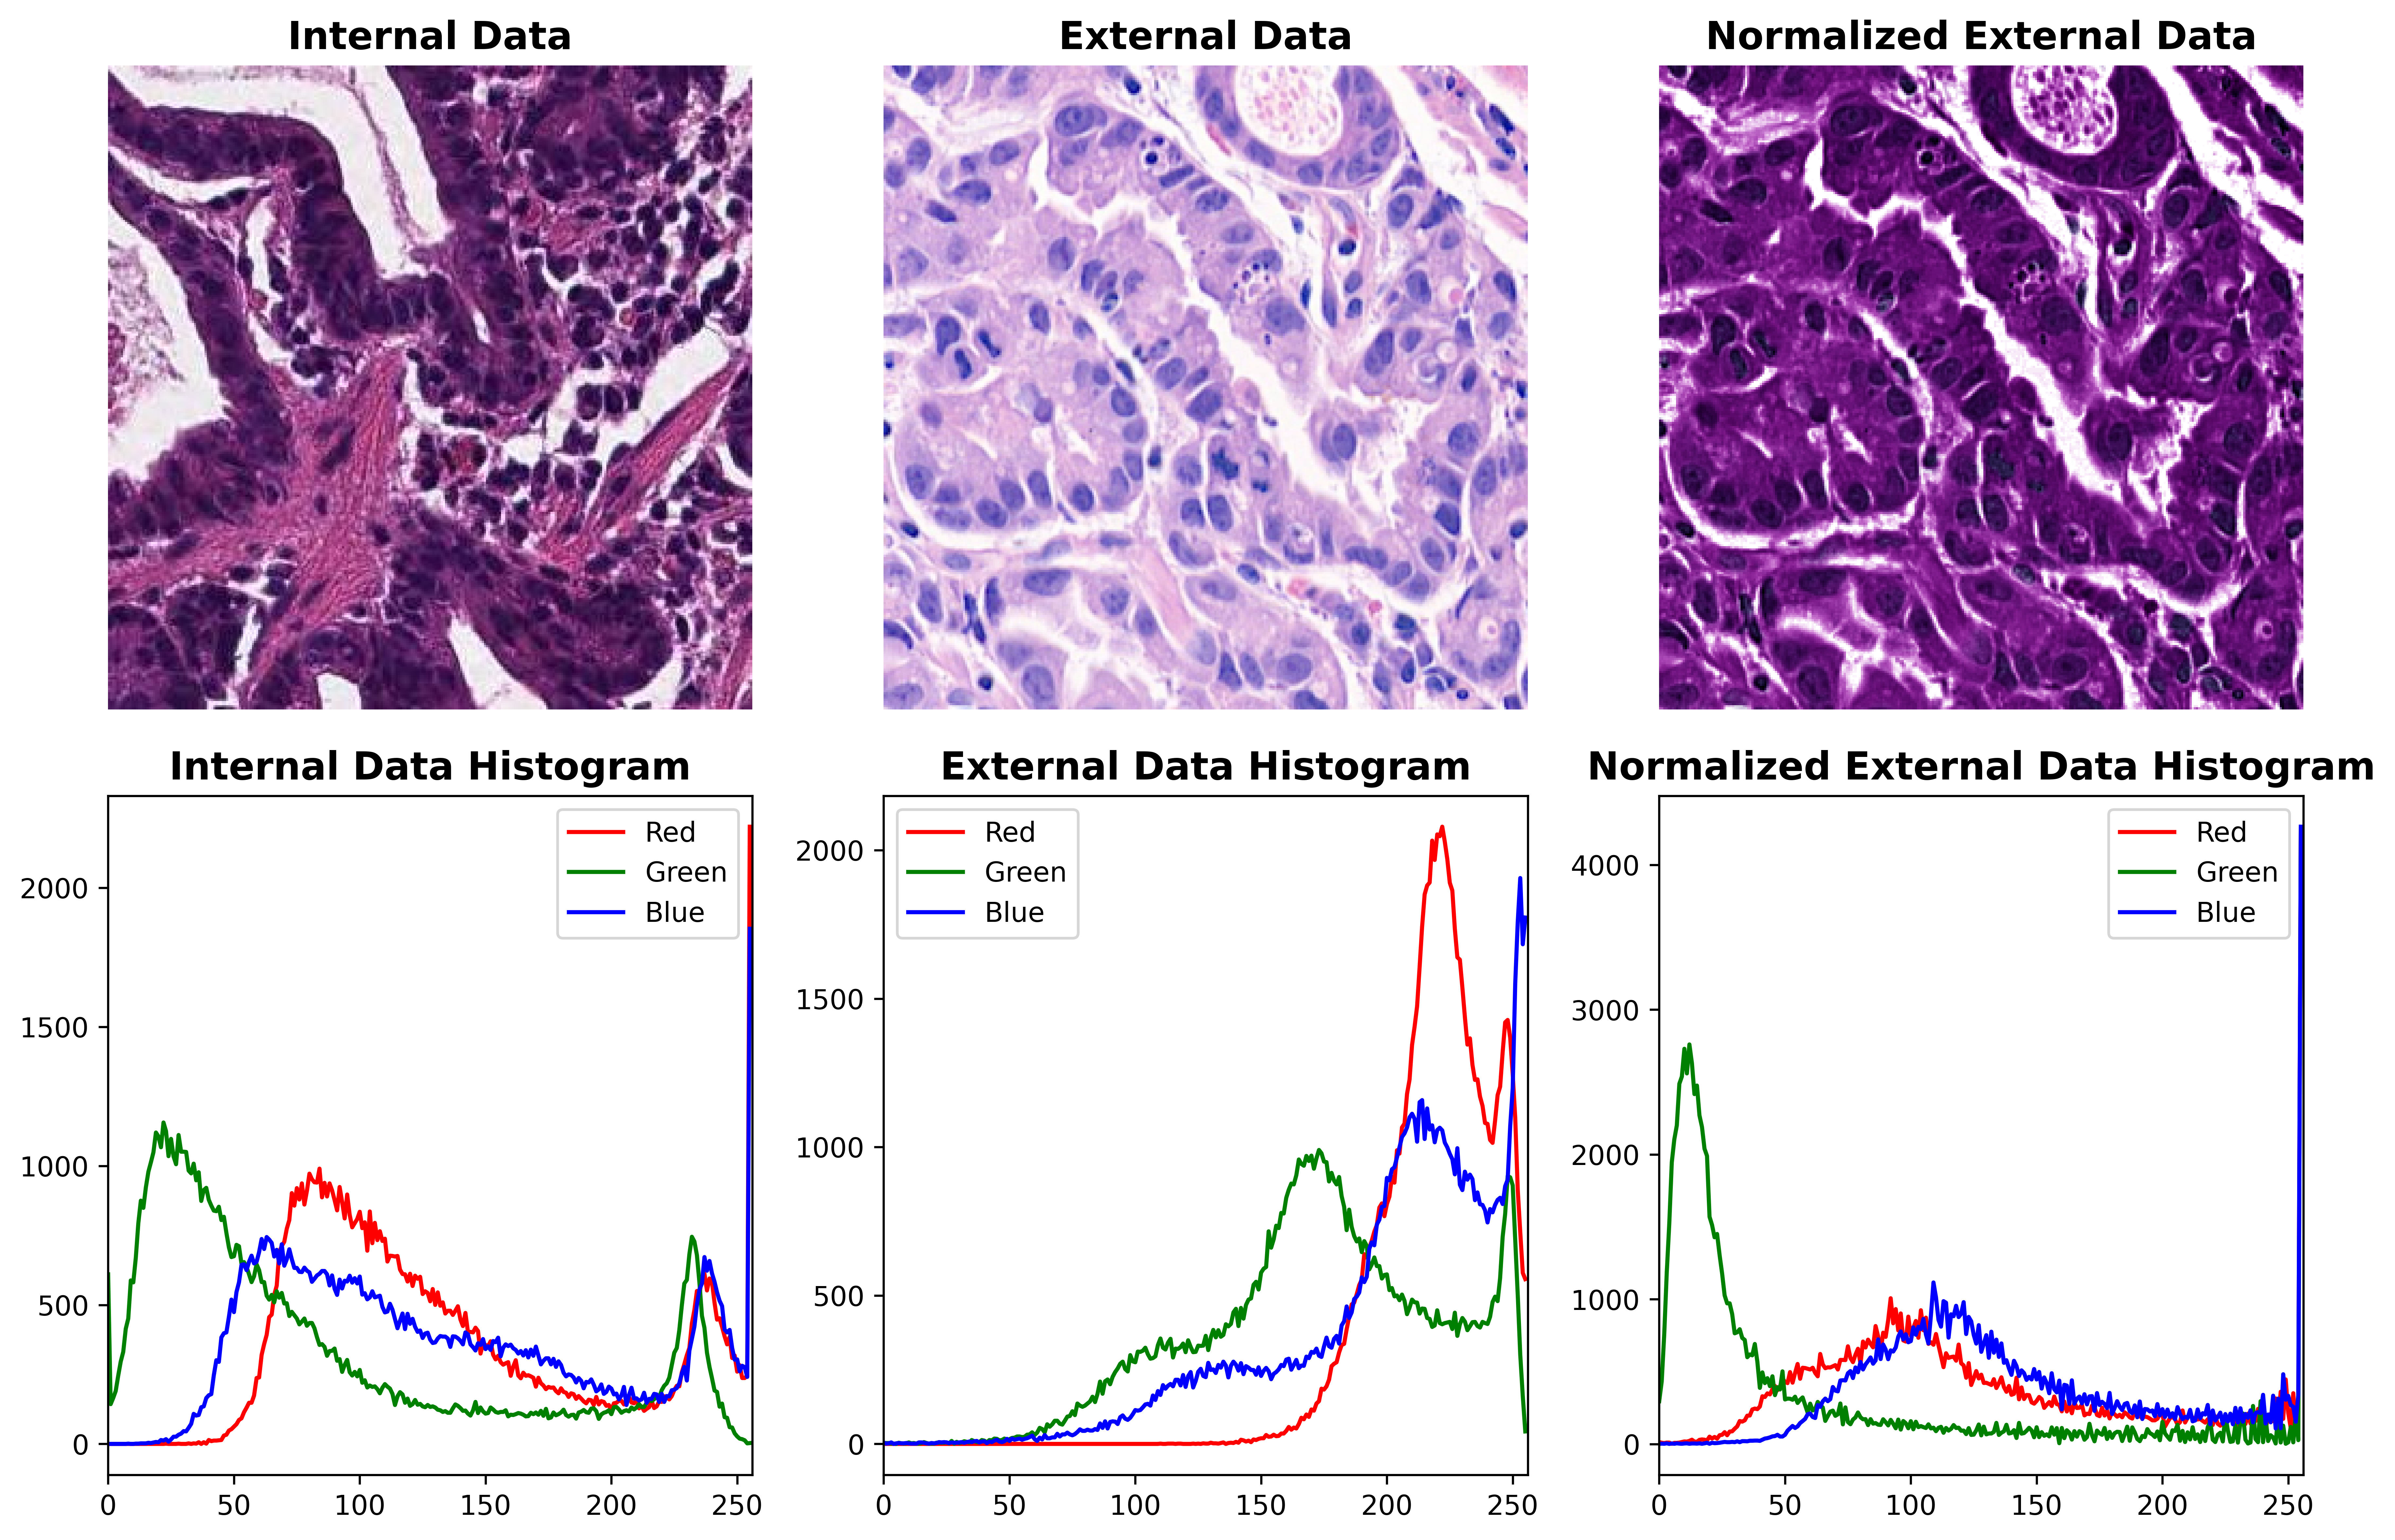

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import staintools

# 이미지 경로 설정
image1_path = '../../data/PatchGastricADC22/f_patches_captions/004cabe20bdb47fcae3022dab96f7f51/004cabe20bdb47fcae3022dab96f7f51_8c0b0b.jpg'
image2_path = '../../data/gcu_svs/svs/S22-11270/110_179.png'

# Macenko 전처리 함수 정의
def apply_macenko_normalization(target_image, reference_image):
    target_image_stain = staintools.LuminosityStandardizer.standardize(target_image)
    reference_image_stain = staintools.LuminosityStandardizer.standardize(reference_image)

    normalizer = staintools.StainNormalizer(method='macenko')
    normalizer.fit(target_image)

    normalized_image = normalizer.transform(reference_image_stain)
    return normalized_image

# 히스토그램 계산 함수 정의
def calculate_histogram(image):
    hist = []
    for i in range(3):  # 0: Red, 1: Green, 2: Blue
        hist.append(cv2.calcHist([image], [i], None, [256], [0, 256]))
    return hist

# 이미지 로드
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# BGR을 RGB로 변환
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Macenko Normalization 적용
normalized_image1 = apply_macenko_normalization(image1_rgb, image2_rgb)

# 히스토그램 계산
hist1 = calculate_histogram(image1)
hist2 = calculate_histogram(image2)
hist_normalized = calculate_histogram(normalized_image1)

# 플롯: 글자 크기와 제목 bold 처리
fig, axs = plt.subplots(2, 3, figsize=(12, 8), dpi=600)

# 폰트 크기 설정
title_font = {'fontsize': 14, 'fontweight': 'bold'}
label_font = {'fontsize': 12}

# 첫 번째 이미지 표시
axs[0, 0].imshow(image1_rgb)
axs[0, 0].set_title("Internal Data", **title_font)
axs[0, 0].axis("off")

# 두 번째 이미지 표시
axs[0, 1].imshow(image2_rgb)
axs[0, 1].set_title("External Data", **title_font)
axs[0, 1].axis("off")

# Macenko Normalized 이미지 표시
axs[0, 2].imshow(normalized_image1)
axs[0, 2].set_title("Normalized External Data", **title_font)
axs[0, 2].axis("off")

# 첫 번째 이미지의 히스토그램
for i, color in enumerate(['red', 'green', 'blue']):
    axs[1, 0].plot(hist1[i], color=color, label=f'{color.capitalize()}')
axs[1, 0].set_title("Internal Data Histogram", **title_font)
axs[1, 0].set_xlim([0, 256])
axs[1, 0].legend(fontsize=10)

# 두 번째 이미지의 히스토그램
for i, color in enumerate(['red', 'green', 'blue']):
    axs[1, 1].plot(hist2[i], color=color, label=f'{color.capitalize()}')
axs[1, 1].set_title("External Data Histogram", **title_font)
axs[1, 1].set_xlim([0, 256])
axs[1, 1].legend(fontsize=10)

# Macenko Normalized 이미지의 히스토그램
for i, color in enumerate(['red', 'green', 'blue']):
    axs[1, 2].plot(hist_normalized[i], color=color, label=f'{color.capitalize()}')
axs[1, 2].set_title("Normalized External Data Histogram", **title_font)
axs[1, 2].set_xlim([0, 256])
axs[1, 2].legend(fontsize=10)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()
